In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from sklearn.experimental import enable_iterative_imputer # imperative to enable IterativeImputer
from sklearn.impute import IterativeImputer

In [179]:
def get_NA_info(data_frame: pd.DataFrame, feature_columns: list):
    sorted_features = []

    for feat in feature_columns:
        df_NAs = data_frame[feat].isna().sum()
        df_total = data_frame.shape[0]

        sorted_features.append((feat, df_NAs, df_total))

    sorted_features.sort(reverse=True, key=lambda x: (x[1]))

    print(f"{'Feature':14s} {'df NA/Total':15s} {'Total, %'}")
    print("----------------------------------------")

    # Iterate through the sorted features and print the missing values information
    for feat, df_na, df_total in sorted_features:
        print(f"{feat:13s} {df_na:5d}/{df_total:5d} {'':5s} {df_na/df_total*100:.2f}%")

def plot_the_features(df: pd.DataFrame, features: list, target: str):

    for feat in features:
        print(feat) # to faster identify the plot using Ctrl + F
        fig, axes = plt.subplots(ncols=5, figsize=(20, 4))

        sns.histplot(df[feat], kde=True, ax=axes[0]) # plotting the feature distribution
        stats.probplot(df[feat], plot=axes[1]) # QQ plot to know how close it is to the normal
        sns.histplot(np.log1p(df[feat]), kde=True, ax=axes[2])
        stats.probplot(np.log1p(df[feat]), plot=axes[3])
        # scatter point to look at outliers and handle them visually as well
        sns.scatterplot(x=df[feat], y=df[target], ax=axes[4])

        axes[0].set_title(f'{feat} distribution')
        axes[1].set_title(f'{feat} QQ plot')
        axes[2].set_title(f'log(1+x) {feat} distribution')
        axes[3].set_title(f'log(1+x) {feat} QQ plot')
        axes[4].set_title(f'{feat} visual outliers')

        plt.show()

## Import and explore the data

In [180]:
data_folder_path = "data\DataHourlyChina"
TARGET = "PM2.5"
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
df = pd.read_csv(os.path.join(data_folder_path, "PRSA_Data_Aotizhongxin_20130301-20170228.csv"), index_col=0)
df.head()

,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM,station
No,,,,,,,,,,,,,,,,,
1,2013,3,1,0,4.0,4.0,4.0,7.0,300.0,77.0,-0.7,1023.0,-18.8,0.0,NNW,4.4,Aotizhongxin
2,2013,3,1,1,8.0,8.0,4.0,7.0,300.0,77.0,-1.1,1023.2,-18.2,0.0,N,4.7,Aotizhongxin
3,2013,3,1,2,7.0,7.0,5.0,10.0,300.0,73.0,-1.1,1023.5,-18.2,0.0,NNW,5.6,Aotizhongxin
4,2013,3,1,3,6.0,6.0,11.0,11.0,300.0,72.0,-1.4,1024.5,-19.4,0.0,NW,3.1,Aotizhongxin
5,2013,3,1,4,3.0,3.0,12.0,12.0,300.0,72.0,-2.0,1025.2,-19.5,0.0,N,2.0,Aotizhongxin


In [181]:
df.drop(columns=["station"], inplace=True)
df.head()

,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM
No,,,,,,,,,,,,,,,,
1,2013,3,1,0,4.0,4.0,4.0,7.0,300.0,77.0,-0.7,1023.0,-18.8,0.0,NNW,4.4
2,2013,3,1,1,8.0,8.0,4.0,7.0,300.0,77.0,-1.1,1023.2,-18.2,0.0,N,4.7
3,2013,3,1,2,7.0,7.0,5.0,10.0,300.0,73.0,-1.1,1023.5,-18.2,0.0,NNW,5.6
4,2013,3,1,3,6.0,6.0,11.0,11.0,300.0,72.0,-1.4,1024.5,-19.4,0.0,NW,3.1
5,2013,3,1,4,3.0,3.0,12.0,12.0,300.0,72.0,-2.0,1025.2,-19.5,0.0,N,2.0


In [182]:
object_features = [feat for feat in df.columns if df[feat].dtype == "O"]
display("Object features:", object_features)

numeric_features = [feat for feat in df.columns if df[feat].dtype != "O"]
display("Numeric features:", numeric_features)

'Object features:'

['wd']

'Numeric features:'

['year',
 'month',
 'day',
 'hour',
 'PM2.5',
 'PM10',
 'SO2',
 'NO2',
 'CO',
 'O3',
 'TEMP',
 'PRES',
 'DEWP',
 'RAIN',
 'WSPM']

## Check for data consistency

#### Row duplicates

In [183]:
duplicate_rows = df[df.duplicated()]
duplicate_rows

,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM
No,,,,,,,,,,,,,,,,


#### Date consistency

Does the dataset have different time intervals?


time_diff
0 days 01:00:00    35063
Name: count, dtype: int64

----------------------------------------------
Does the dataset have duplicate rows?


,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM,datetime,time_diff
No,,,,,,,,,,,,,,,,,,


----------------------------------------------
Time gaps analysis plotted


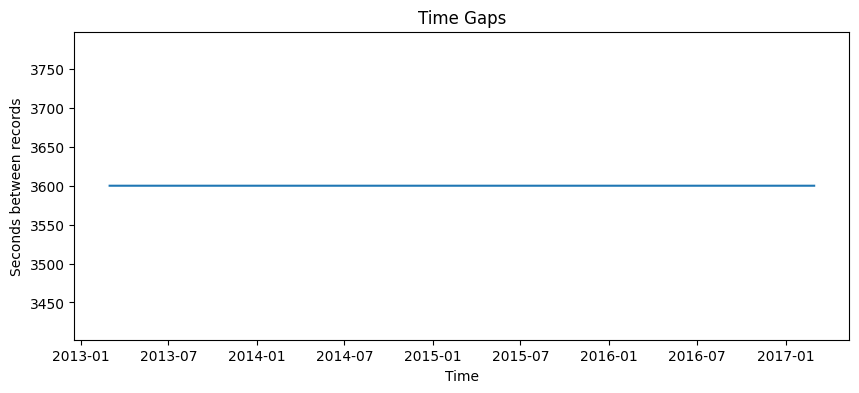

In [190]:
df['datetime'] = pd.to_datetime(df[['year', 'month', 'day', 'hour']])
df = df.sort_values('datetime')
df['time_diff'] = df['datetime'].diff()

print("Does the dataset have different time intervals?")
display(df['time_diff'].value_counts().sort_index())

print("----------------------------------------------")

print("Does the dataset have duplicate rows?")
display(df[df['datetime'].duplicated()])

print("----------------------------------------------")

print("Time gaps analysis plotted")
plt.figure(figsize=(10,4))
plt.plot(df['datetime'], df['time_diff'].dt.total_seconds())
plt.ylabel('Seconds between records')
plt.xlabel('Time')
plt.title('Time Gaps')
plt.show()

## Check the target balance

Unique target values:


PM2.5
9.0      600
10.0     590
12.0     576
11.0     570
8.0      563
        ... 
444.0      1
505.0      1
565.0      1
587.0      1
462.0      1
Name: count, Length: 545, dtype: int64

----------------------------
Target distribution


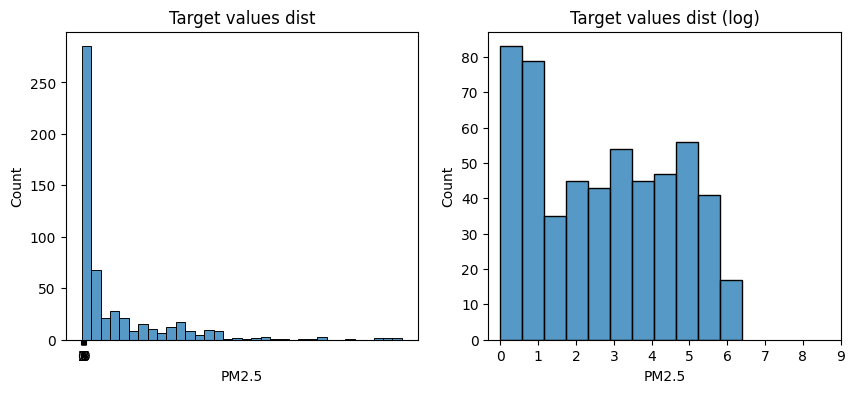

In [206]:
print("Unique target values:")
target_values = df[TARGET].value_counts()
display(target_values)

print("----------------------------")

print("Target distribution")

fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(10,4))

sns.histplot(target_values.values, ax=ax[0])
new_tick_locations = [x for x in range(10)]
ax[0].set_xticks(new_tick_locations)
ax[0].set_title('Target values dist')
ax[0].set_xlabel(TARGET)

sns.histplot(np.log(target_values.values), ax=ax[1])
new_tick_locations = [x for x in range(10)]
ax[1].set_xticks(new_tick_locations)
ax[1].set_title('Target values dist (log)')
ax[1].set_xlabel(TARGET)

plt.show()

#### The target is imbalanced as most values cluster around smaller numbers. It is already expected that the model is unlikely to be precise enough with larger values. 
#### Since it's time series analysis we may not break time relation, therefore any stratified sampling strategies (including under- and oversampling) are invalid. The expected improving factor to pay attention to more: feature analysis. 

## Check for missing values

In [6]:
# print object feature nulls
print("Object feature nulls:")

get_NA_info(df, object_features)

Object feature nulls:
Feature        df NA/Total     Total, %
----------------------------------------
wd               81/35064       0.23%


In [7]:
# print numeric feature nulls
print("Numeric feature nulls:")

get_NA_info(df, numeric_features)

Numeric feature nulls:
Feature        df NA/Total     Total, %
----------------------------------------
CO             1776/35064       5.07%
O3             1719/35064       4.90%
NO2            1023/35064       2.92%
SO2             935/35064       2.67%
PM2.5           925/35064       2.64%
PM10            718/35064       2.05%
TEMP             20/35064       0.06%
PRES             20/35064       0.06%
DEWP             20/35064       0.06%
RAIN             20/35064       0.06%
WSPM             14/35064       0.04%
year              0/35064       0.00%
month             0/35064       0.00%
day               0/35064       0.00%
hour              0/35064       0.00%


In [126]:
df_no_nulls_for_visualization = df.dropna()

## Visualize numerical columns

year


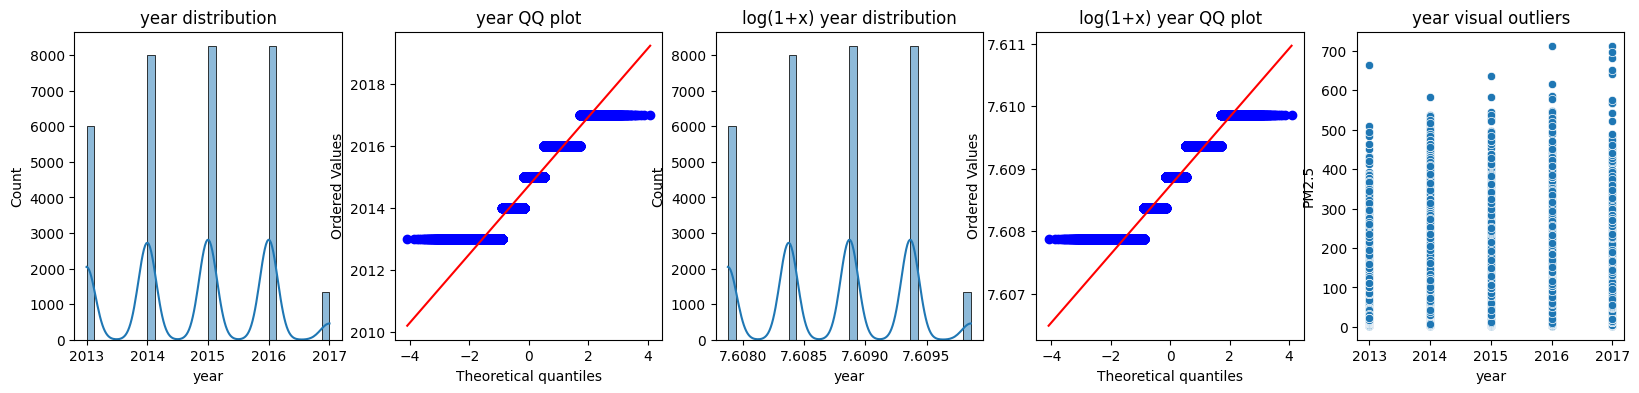

month


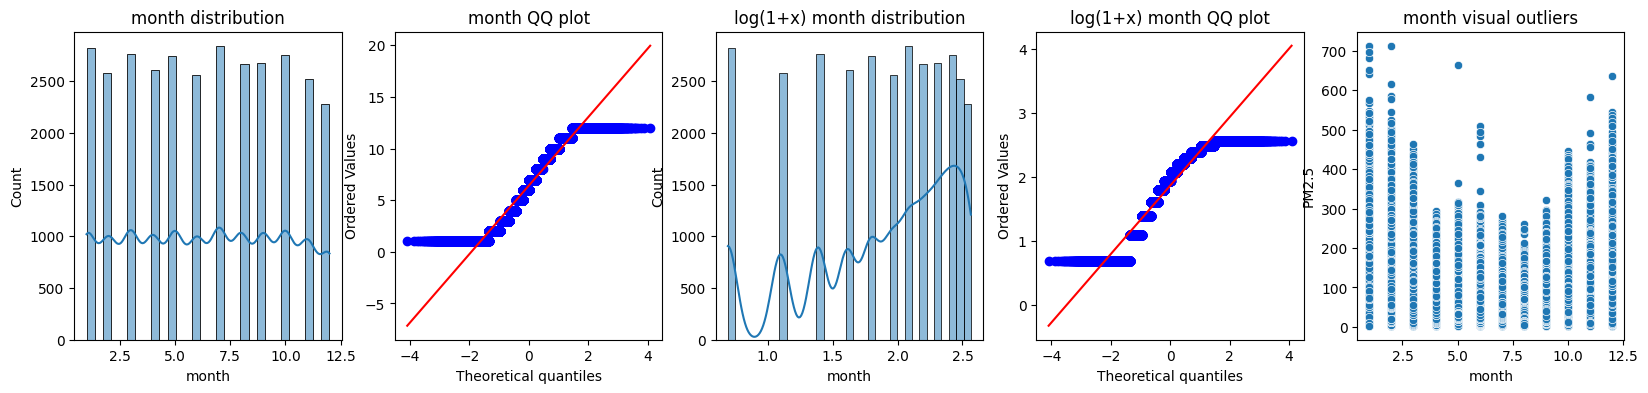

day


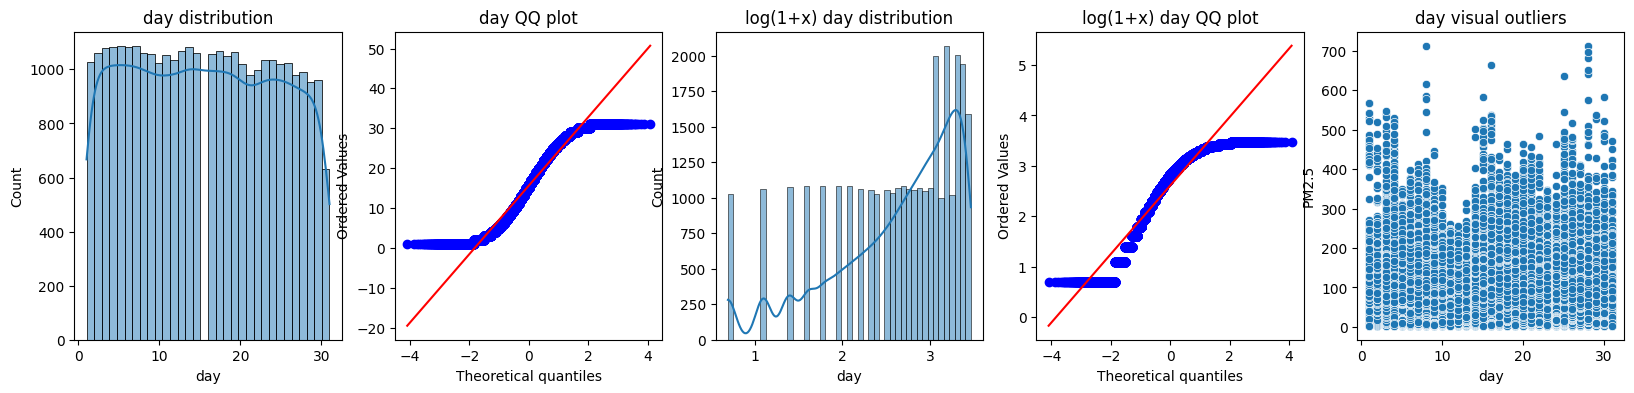

hour


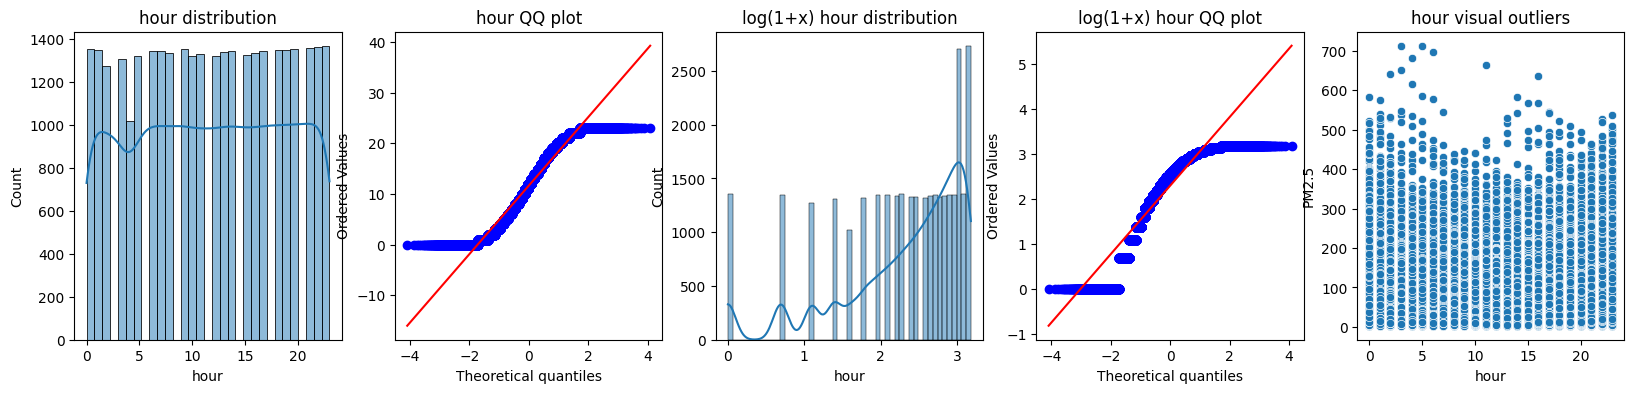

PM2.5


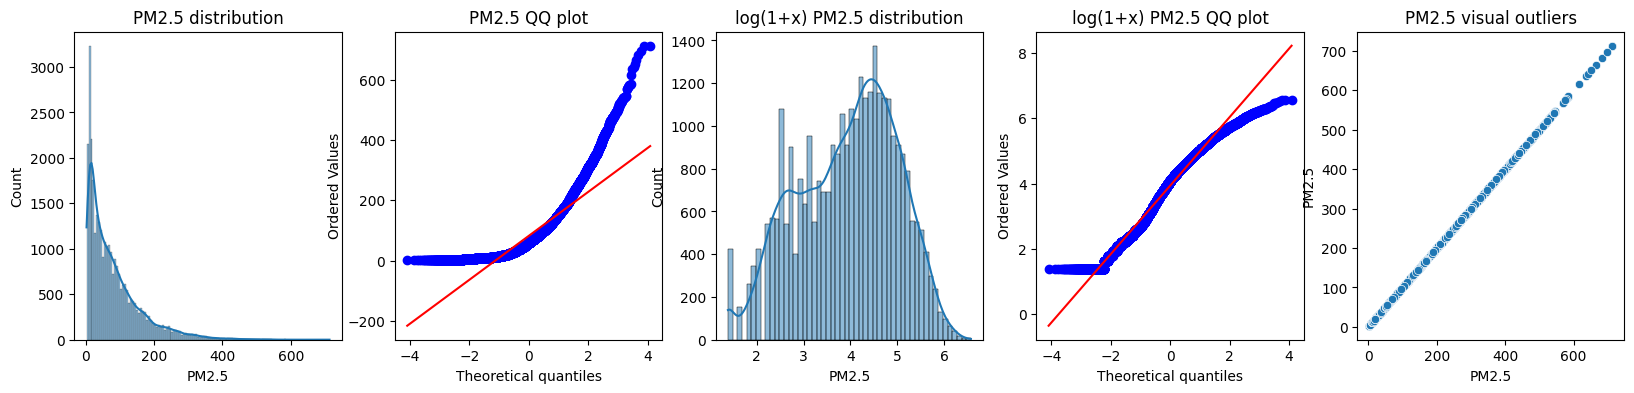

PM10


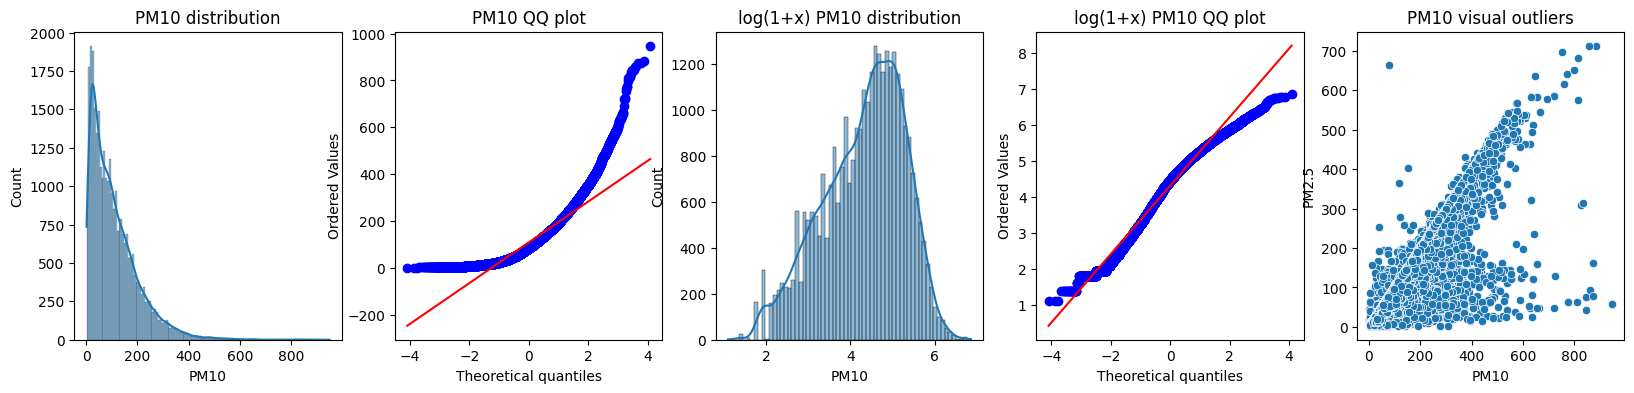

SO2


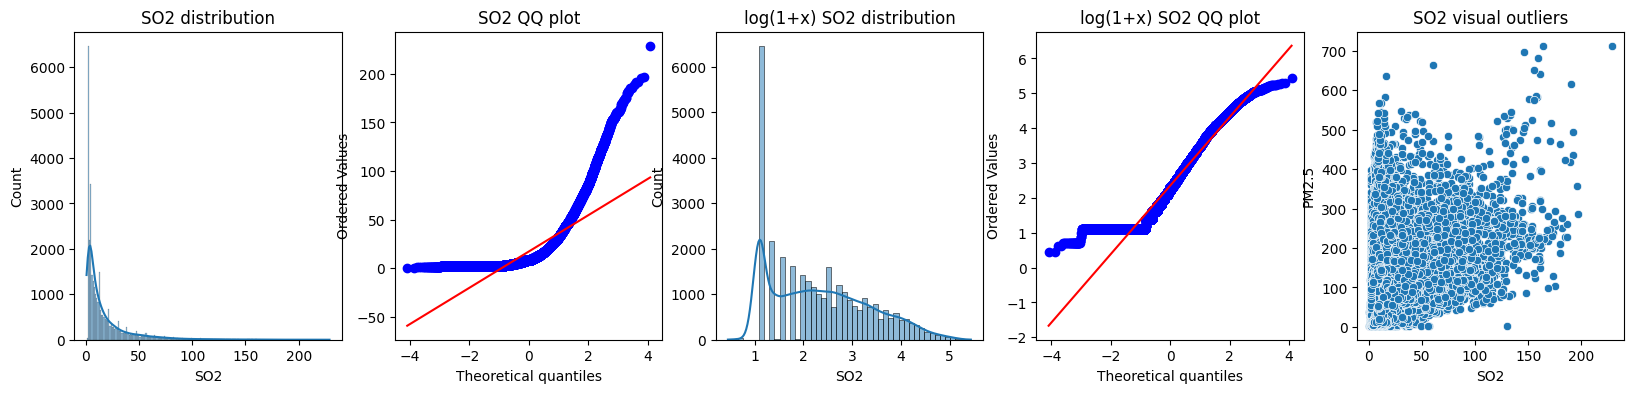

NO2


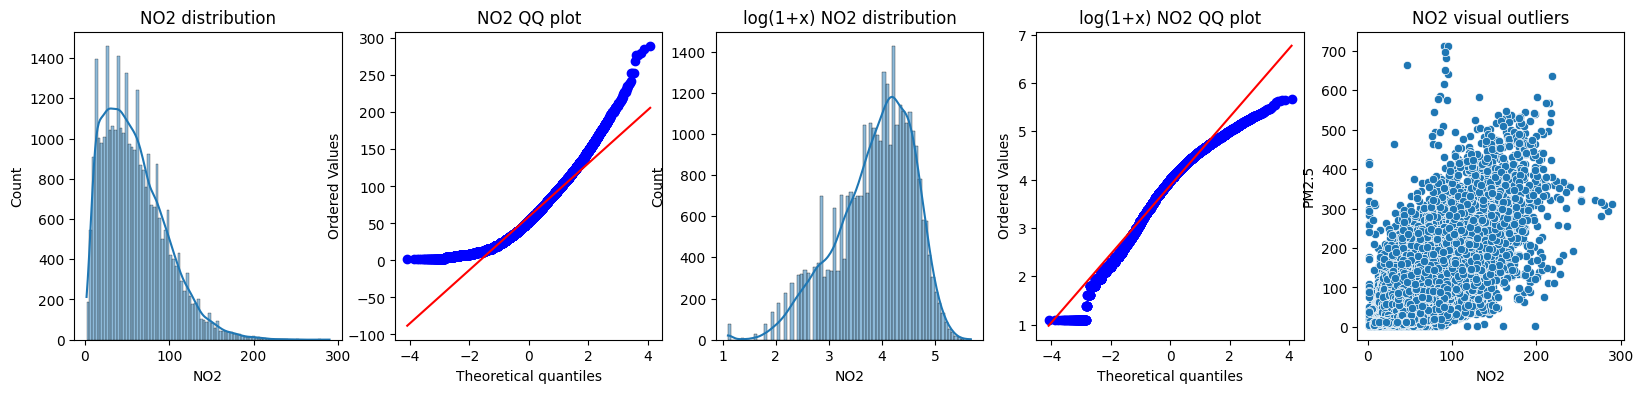

CO


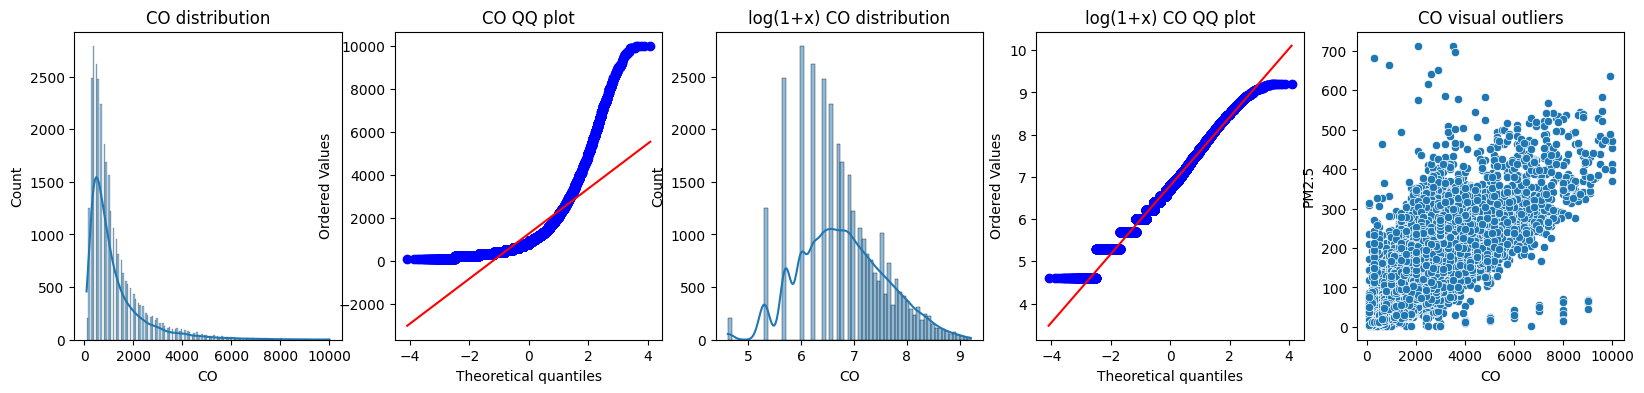

O3


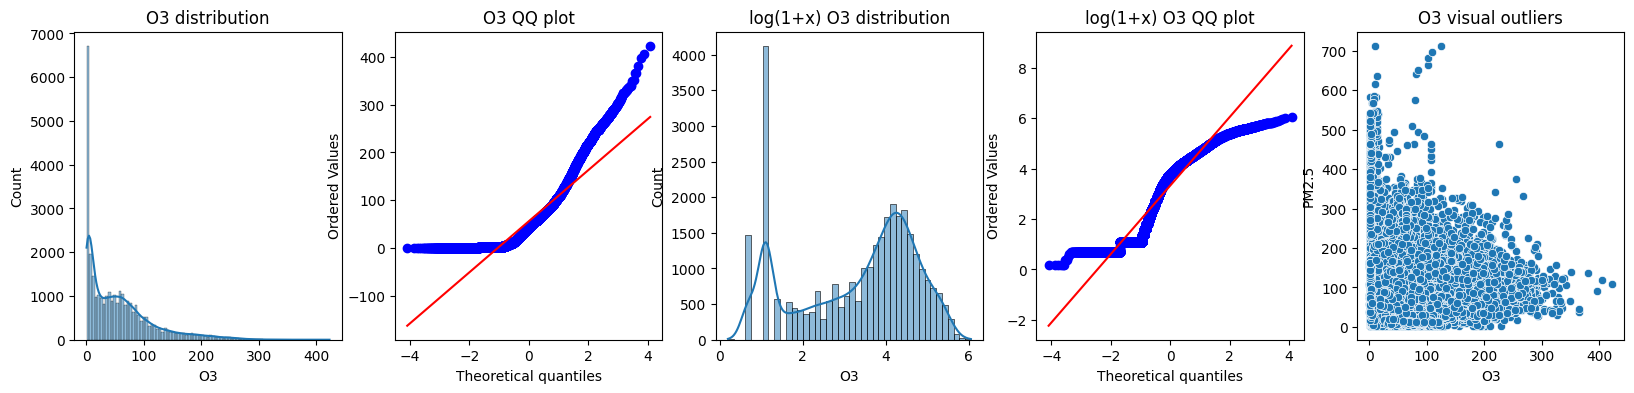

TEMP


c:\Users\Yur4ik\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\Yur4ik\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\Yur4ik\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\Yur4ik\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


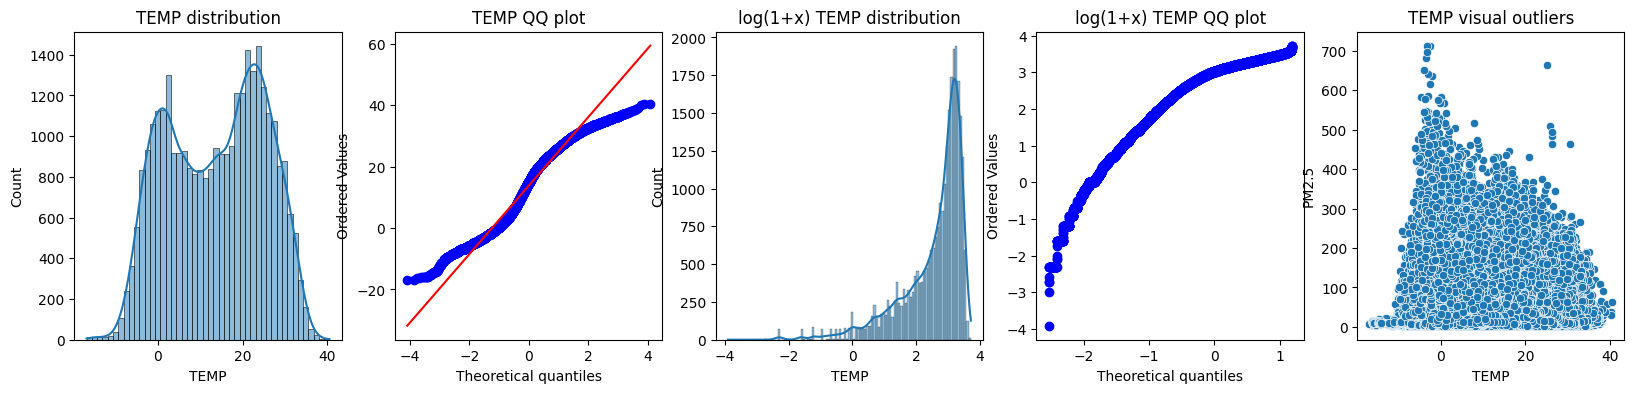

PRES


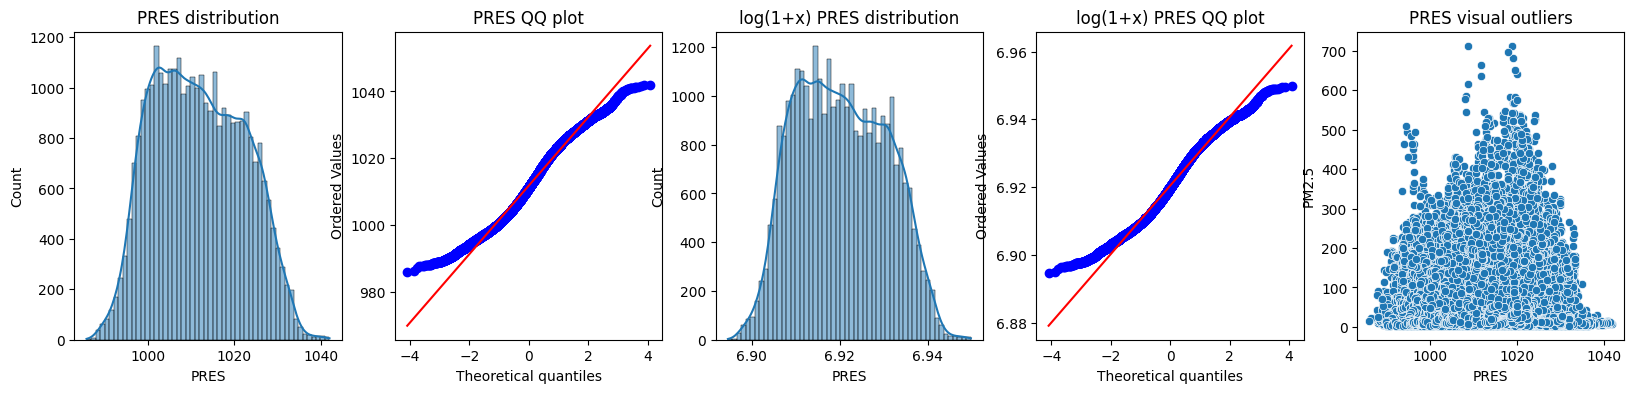

DEWP


c:\Users\Yur4ik\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\Yur4ik\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\Yur4ik\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\Yur4ik\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


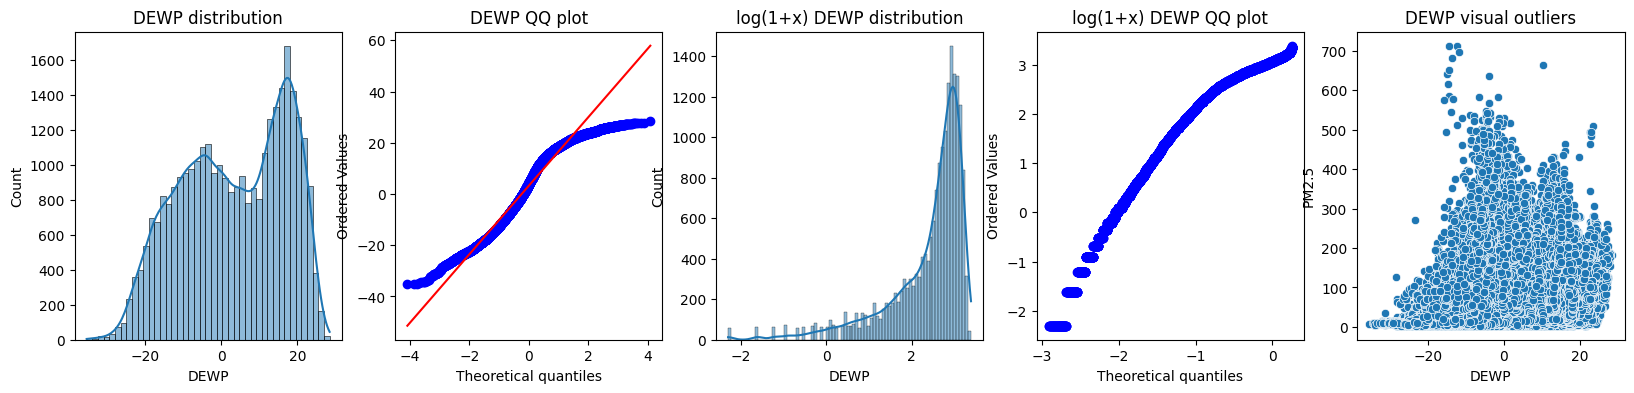

RAIN


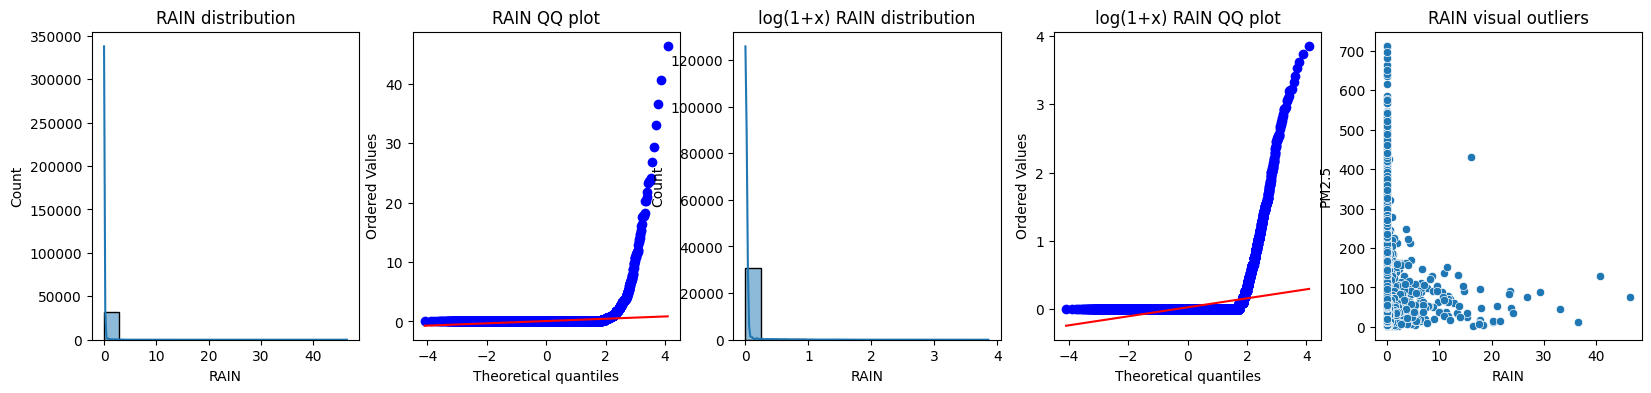

WSPM


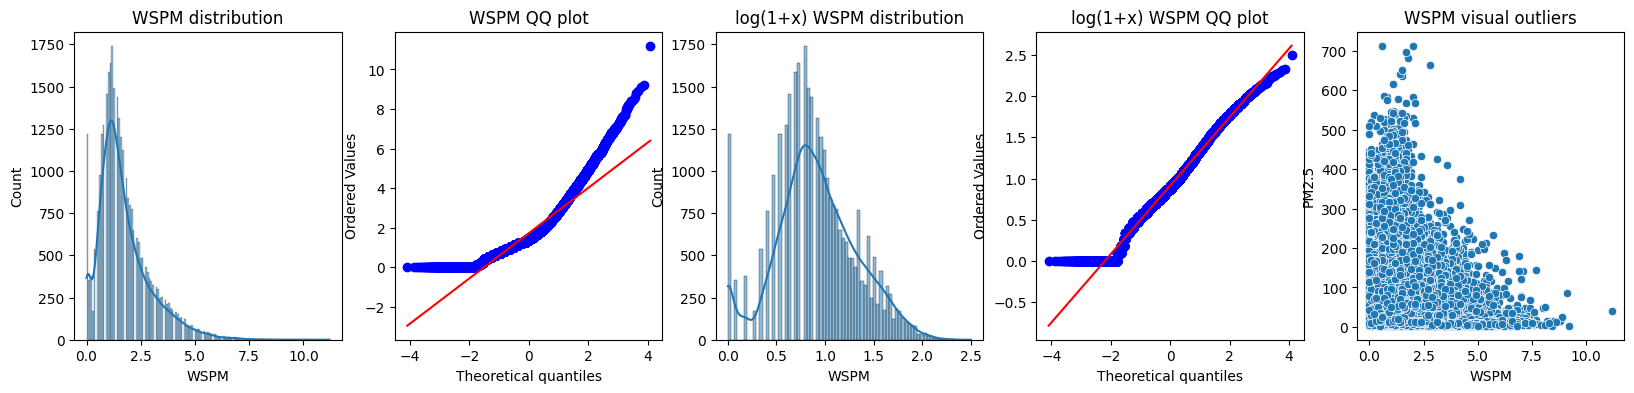

In [ ]:
plot_the_features(df_no_nulls_for_visualization, numeric_features, TARGET)

## Assess cardinality of the categorical

##### The only categorical is 'wd' and it happens not to have too many unique values. No grouping needed. It's imbalanced though, the spread is: 5140/1022 = 5.03 times.

In [8]:
value_counts = df['wd'].value_counts()
value_counts

wd
NE     5140
ENE    3950
SW     3359
E      2608
NNE    2445
WSW    2212
SSW    2098
N      2066
NW     1860
ESE    1717
NNW    1589
SE     1341
S      1304
W      1171
WNW    1101
SSE    1022
Name: count, dtype: int64

## Deal with outliers

##### Having assessed visually, the following rules are being applied:

In [9]:
outlier_indexes = set()
outlier_indexes.add(df[df['PM10'] == max(df['PM10'])].index[0])
outlier_indexes.add(df[df['PM10'] == max(df['PM10'])].index[0])
outlier_indexes.add(df[df['SO2'] > 200].index[0])
outlier_indexes.add(df[(df['SO2'] == 130) & (df['PM2.5'] == 3)].index[0])
outlier_indexes.add(df[(df['TEMP'] > 20) & (df['PM2.5'] > 600)].index[0])
outlier_indexes.add(df[(df['RAIN'] > 10) & (df['PM2.5'] > 400)].index[0])
outlier_indexes.add(df[df['WSPM'] > 10].index[0])
outlier_indexes


{348, 1836, 2878, 17346, 18619, 25779}

In [10]:
display("Before dropping:", df.shape)
df.drop(outlier_indexes, inplace=True)
display("After dropping:", df.shape)

'Before dropping:'

(35064, 16)

'After dropping:'

(35058, 16)

## Encode the categoric

##### We only have one categoric column 'wd', it's nominal

In [11]:
# Step 1: Initialize the OneHotEncoder
encoder = OneHotEncoder(drop='first', sparse_output=False) # we drop first to avoid perfect multicollinearity from nominals

# Step 2: Fit and transform the 'wd' column
encoded_cols = encoder.fit_transform(df.dropna()[['wd']])

# Step 3: Create a DataFrame with proper column names
encoded_df = pd.DataFrame(encoded_cols, columns=encoder.get_feature_names_out(['wd']),
                          index=df.dropna().index)

# Step 4: Concatenate with the original DataFrame (dropping 'wd')
df = pd.concat([df.drop('wd', axis=1), encoded_df], axis=1)
df.head()

,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,O3,...,wd_NNW,wd_NW,wd_S,wd_SE,wd_SSE,wd_SSW,wd_SW,wd_W,wd_WNW,wd_WSW
No,,,,,,,,,,,,,,,,,,,,,
1,2013,3,1,0,4.0,4.0,4.0,7.0,300.0,77.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2013,3,1,1,8.0,8.0,4.0,7.0,300.0,77.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2013,3,1,2,7.0,7.0,5.0,10.0,300.0,73.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2013,3,1,3,6.0,6.0,11.0,11.0,300.0,72.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,2013,3,1,4,3.0,3.0,12.0,12.0,300.0,72.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [131]:
df.columns # to make sure we didn't miss anything

Index(['year', 'month', 'day', 'hour', 'PM2.5', 'PM10', 'SO2', 'NO2', 'CO',
       'O3', 'TEMP', 'PRES', 'DEWP', 'RAIN', 'WSPM', 'wd_ENE', 'wd_ESE',
       'wd_N', 'wd_NE', 'wd_NNE', 'wd_NNW', 'wd_NW', 'wd_S', 'wd_SE', 'wd_SSE',
       'wd_SSW', 'wd_SW', 'wd_W', 'wd_WNW', 'wd_WSW'],
      dtype='object')

In [12]:
nominal_dummy_cols = [col for col in df.columns if col.startswith('wd_')]
nominal_dummy_cols

['wd_ENE',
 'wd_ESE',
 'wd_N',
 'wd_NE',
 'wd_NNE',
 'wd_NNW',
 'wd_NW',
 'wd_S',
 'wd_SE',
 'wd_SSE',
 'wd_SSW',
 'wd_SW',
 'wd_W',
 'wd_WNW',
 'wd_WSW']

## Build correlation matrices

##### Relationship between numerical features and the target

In [13]:
def plot_correlations(data_frame: pd.DataFrame, features_to_plot: list, title: str, threshold: float = 0.0):
    correlations = data_frame[features_to_plot].corr()
    
    # Find features that have any strong correlation (excluding self-correlation)
    mask = (abs(correlations) >= threshold) & (~np.eye(len(correlations), dtype=bool))
    keep_features = correlations.columns[mask.any(axis=1)]

    # Filter to those features
    filtered = correlations.loc[keep_features, keep_features]

    if filtered.empty:
        print(f"No entries to plot for a threshold of {threshold}")
        return

    np.fill_diagonal(filtered.values, np.nan)

    plt.figure(figsize=(15, 15))
    sns.heatmap(filtered, annot=True, fmt=".2f")

    if threshold != 0.0:
        title = title + f' (|corr| ≥ {threshold})'

    plt.title(title)
    plt.show()

    return correlations

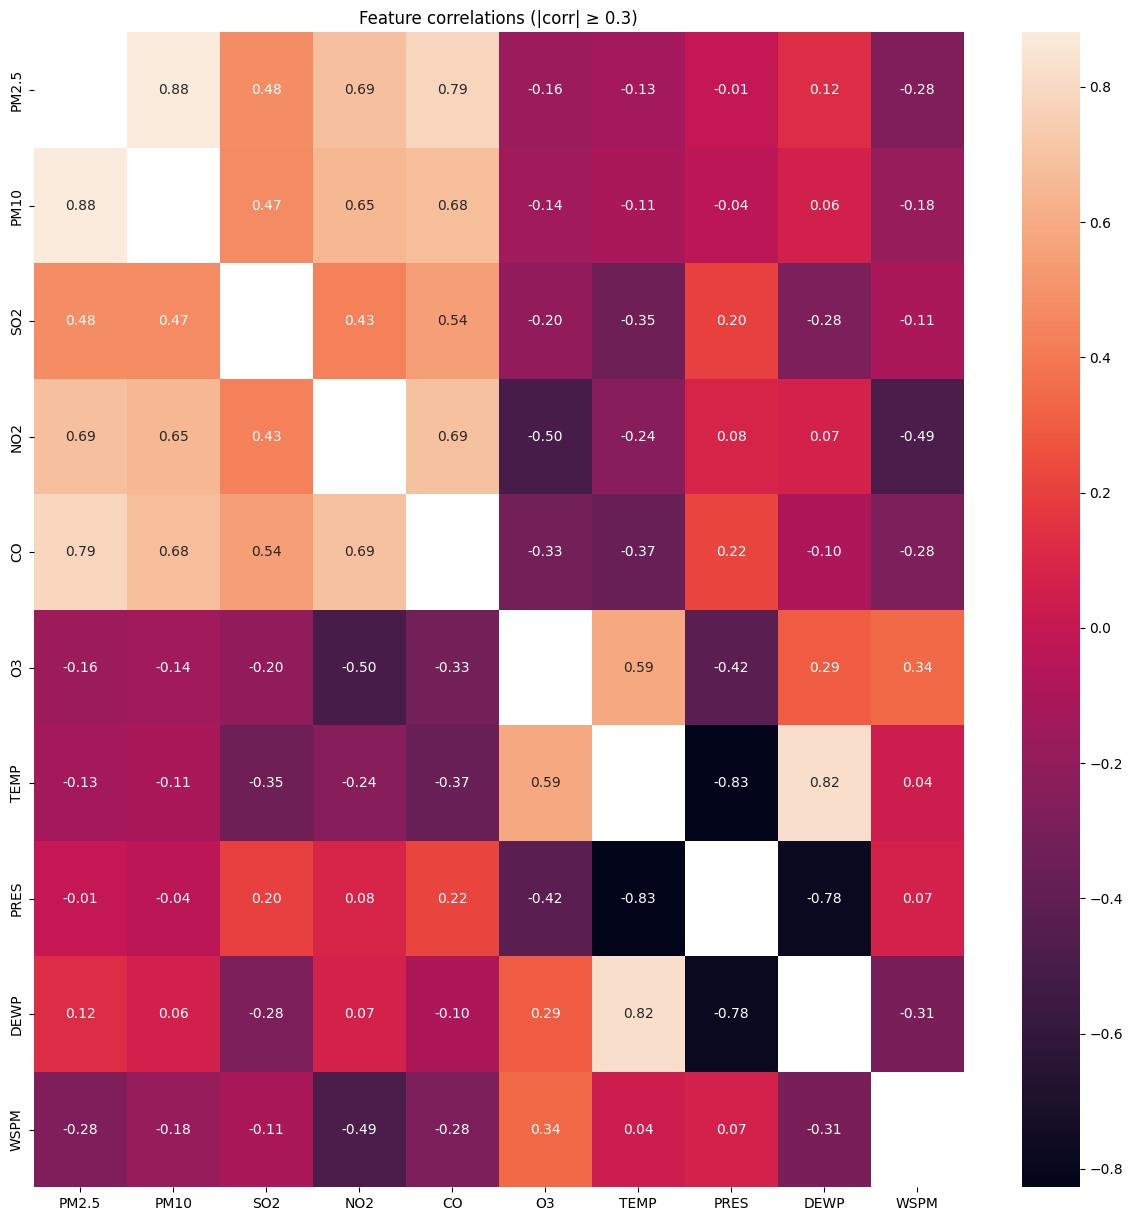

In [14]:
plot_correlations(df, numeric_features + nominal_dummy_cols, f'Feature correlations', 0.3)
print()

##### Relationship between the encoded categorical and the target features with a threshold

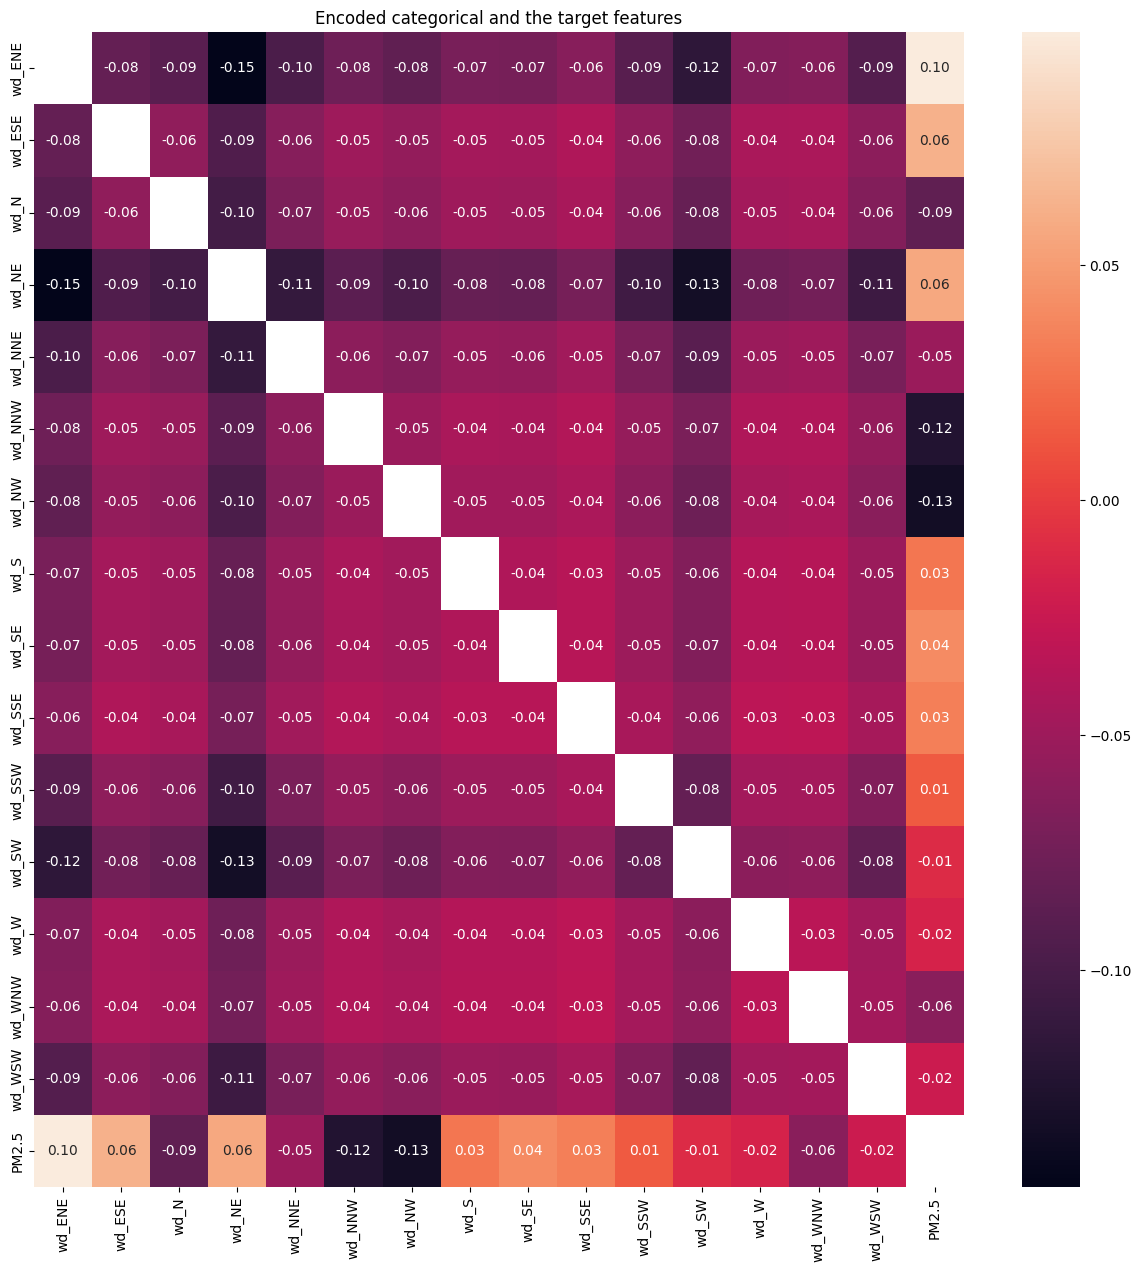

In [15]:
plot_correlations(df, nominal_dummy_cols + [TARGET], f'Encoded categorical and the target features')
print()

##### The 'TEMP' and 'PRES', 'DEWP' and 'PRES' features appear to be highly correlated. We need to explore the problem of multicollinearity

## The problem of multicollinearity

In [16]:
def perform_VIF(data_frame: pd.DataFrame, predictors: list, ascending: str = False):
    X = data_frame.dropna()[predictors].drop(columns=[TARGET])
    X = add_constant(X)

    vif_df = pd.DataFrame()
    vif_df["feature"] = X.columns
    vif_df["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif_df = vif_df[vif_df["feature"] != "const"]
    
    display(vif_df.sort_values(by="VIF", ascending=ascending))

In [17]:
perform_VIF(df, df.dropna().select_dtypes(include=[float, int]).columns.values)

,feature,VIF
10,TEMP,8.644372
12,DEWP,6.804012
11,PRES,4.282090
7,NO2,3.647284
8,CO,3.236923
9,O3,2.818561
5,PM10,2.572343
18,wd_NE,2.551245
26,wd_SW,2.234003
15,wd_ENE,2.233592


##### Values of 'TEMP' = 8.64 and 'DEWP' = 6.8 are moderate and needs to be addressed. We leave the one with higer target correlation ('TEMP').

In [18]:
df = df.drop(columns=["DEWP"])

In [19]:
perform_VIF(df, df.dropna().select_dtypes(include=[float, int]).columns.values)

,feature,VIF
10,TEMP,5.391337
11,PRES,4.004217
7,NO2,3.639933
8,CO,3.150831
9,O3,2.791567
5,PM10,2.567024
17,wd_NE,2.551245
14,wd_ENE,2.233590
25,wd_SW,2.233259
6,SO2,1.999794


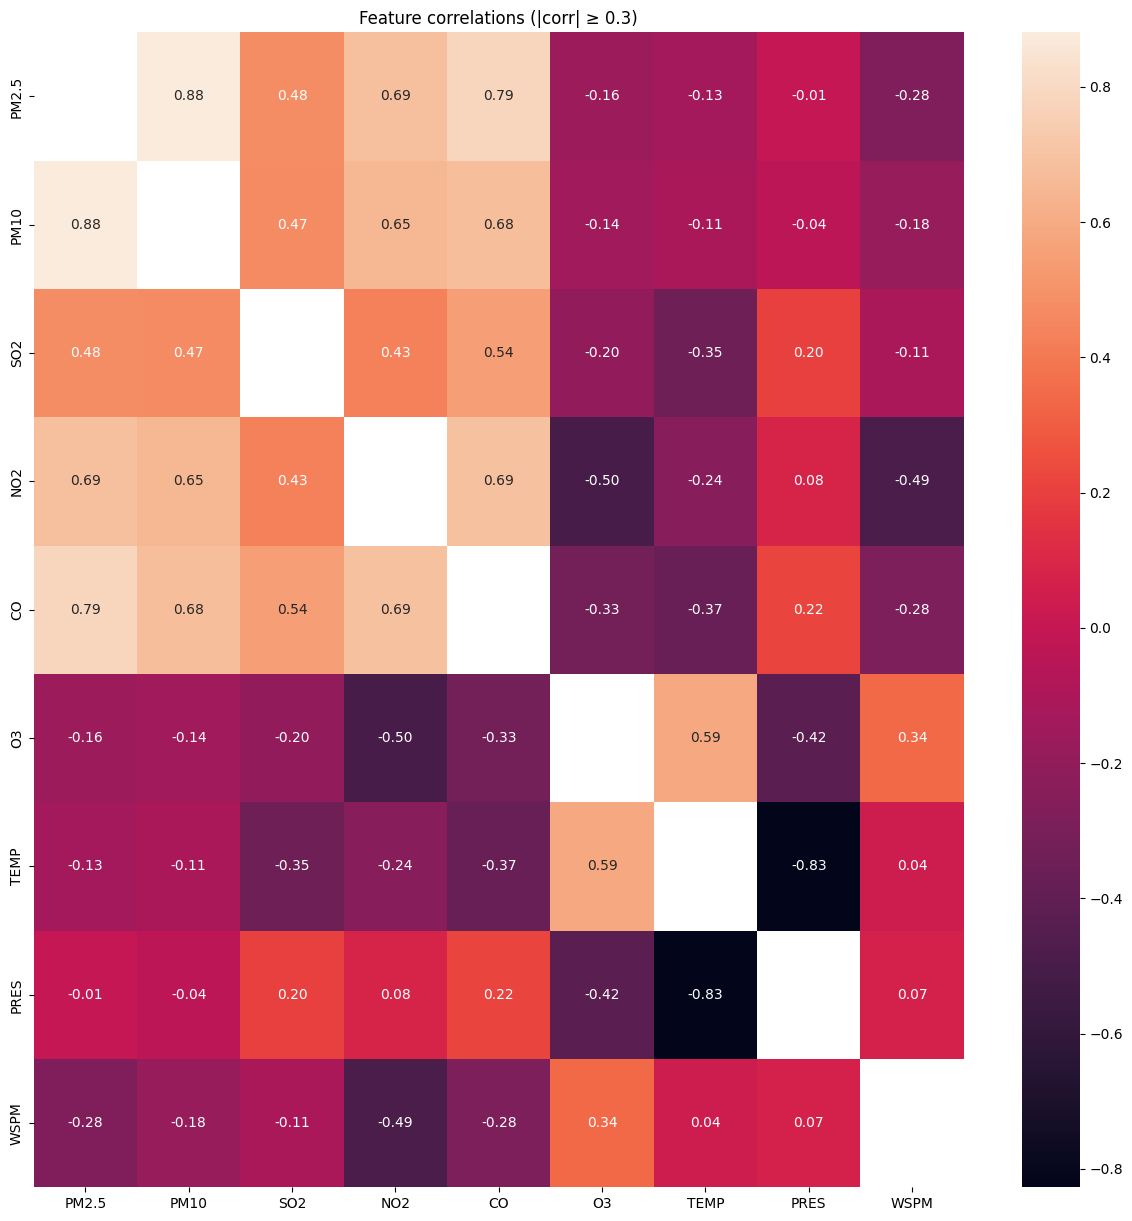

In [20]:
plot_correlations(df, df.columns, f'Feature correlations', 0.3)
print()

##### 'TEMP' and 'PRES' are contentious now. We leave the one with higher correlation ('TEMP').

In [21]:
df = df.drop(columns=["PRES"])

In [22]:
perform_VIF(df, df.dropna().select_dtypes(include=[float, int]).columns.values)

,feature,VIF
7,NO2,3.635869
8,CO,3.142814
9,O3,2.790419
16,wd_NE,2.550933
5,PM10,2.540359
13,wd_ENE,2.233285
24,wd_SW,2.232955
10,TEMP,2.232230
6,SO2,1.992696
17,wd_NNE,1.852133


## Impute nulls

##### The categorical 'wd' doesn't have any strong correlations and a moderate spread (x5).

In [307]:
df_original = pd.read_csv(os.path.join(data_folder_path, "PRSA_Data_Aotizhongxin_20130301-20170228.csv"), index_col=0)
df_original.drop(columns=['station'])

,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM
No,,,,,,,,,,,,,,,,
1,2013,3,1,0,4.0,4.0,4.0,7.0,300.0,77.0,-0.7,1023.0,-18.8,0.0,NNW,4.4
2,2013,3,1,1,8.0,8.0,4.0,7.0,300.0,77.0,-1.1,1023.2,-18.2,0.0,N,4.7
3,2013,3,1,2,7.0,7.0,5.0,10.0,300.0,73.0,-1.1,1023.5,-18.2,0.0,NNW,5.6
4,2013,3,1,3,6.0,6.0,11.0,11.0,300.0,72.0,-1.4,1024.5,-19.4,0.0,NW,3.1
5,2013,3,1,4,3.0,3.0,12.0,12.0,300.0,72.0,-2.0,1025.2,-19.5,0.0,N,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35060,2017,2,28,19,12.0,29.0,5.0,35.0,400.0,95.0,12.5,1013.5,-16.2,0.0,NW,2.4
35061,2017,2,28,20,13.0,37.0,7.0,45.0,500.0,81.0,11.6,1013.6,-15.1,0.0,WNW,0.9
35062,2017,2,28,21,16.0,37.0,10.0,66.0,700.0,58.0,10.8,1014.2,-13.3,0.0,NW,1.1


In [308]:
outlier_indexes = set()
outlier_indexes.add(df_original[df_original['PM10'] == max(df_original['PM10'])].index[0])
outlier_indexes.add(df_original[df_original['PM10'] == max(df_original['PM10'])].index[0])
outlier_indexes.add(df_original[df_original['SO2'] > 200].index[0])
outlier_indexes.add(df_original[(df_original['SO2'] == 130) & (df_original['PM2.5'] == 3)].index[0])
outlier_indexes.add(df_original[(df_original['TEMP'] > 20) & (df_original['PM2.5'] > 600)].index[0])
outlier_indexes.add(df_original[(df_original['RAIN'] > 10) & (df_original['PM2.5'] > 400)].index[0])
outlier_indexes.add(df_original[df_original['WSPM'] > 10].index[0])
display("Before dropping:", df_original.shape)
df_original.drop(outlier_indexes, inplace=True)
display("After dropping:", df_original.shape)

'Before dropping:'

(35064, 17)

'After dropping:'

(35058, 17)

In [309]:
wd_probabilities = df_original['wd'].value_counts(normalize=True)
wd_probabilities*100

wd
NE     14.695371
ENE    11.293135
SW      9.594877
E       7.456328
NNE     6.990308
WSW     6.324156
SSW     5.998227
N       5.903880
NW      5.317780
ESE     4.908940
NNW     4.537267
SE      3.833948
S       3.728164
W       3.347914
WNW     3.147783
SSE     2.921920
Name: proportion, dtype: float64

##### The most frequent category (NE) dominates, but imputing with 'NE' will distort the distribution and introduce bias. There are no strong correlations as well = no predictor-based imputation (e.g. via KNN, IterativeImputer, or decision trees). So predictive imputation is not justifiable either.
##### Since the values are purely nominal, the least biased strategy is random imputation based on existing distribution.

In [310]:
# Only target the nulls
wd_nulls = df_original['wd'].isnull()

# Random choice imputation
df_original.loc[wd_nulls, 'wd'] = np.random.choice(
    wd_probabilities.index,
    size=wd_nulls.sum(),
    p=wd_probabilities.values
)

df_original.head(10)

,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM,station
No,,,,,,,,,,,,,,,,,
1,2013,3,1,0,4.0,4.0,4.0,7.0,300.0,77.0,-0.7,1023.0,-18.8,0.0,NNW,4.4,Aotizhongxin
2,2013,3,1,1,8.0,8.0,4.0,7.0,300.0,77.0,-1.1,1023.2,-18.2,0.0,N,4.7,Aotizhongxin
3,2013,3,1,2,7.0,7.0,5.0,10.0,300.0,73.0,-1.1,1023.5,-18.2,0.0,NNW,5.6,Aotizhongxin
4,2013,3,1,3,6.0,6.0,11.0,11.0,300.0,72.0,-1.4,1024.5,-19.4,0.0,NW,3.1,Aotizhongxin
5,2013,3,1,4,3.0,3.0,12.0,12.0,300.0,72.0,-2.0,1025.2,-19.5,0.0,N,2.0,Aotizhongxin
6,2013,3,1,5,5.0,5.0,18.0,18.0,400.0,66.0,-2.2,1025.6,-19.6,0.0,N,3.7,Aotizhongxin
7,2013,3,1,6,3.0,3.0,18.0,32.0,500.0,50.0,-2.6,1026.5,-19.1,0.0,NNE,2.5,Aotizhongxin
8,2013,3,1,7,3.0,6.0,19.0,41.0,500.0,43.0,-1.6,1027.4,-19.1,0.0,NNW,3.8,Aotizhongxin
9,2013,3,1,8,3.0,6.0,16.0,43.0,500.0,45.0,0.1,1028.3,-19.2,0.0,NNW,4.1,Aotizhongxin


In [311]:
get_NA_info(df_original, ["wd"])

Feature        df NA/Total     Total, %
----------------------------------------
wd                0/35058       0.00%


- PM2.5 (target) - approx. normal with a slight left skew. Mean is suitable.
- PM10 - approx. normal; right skewed, heavier tail. Median is suitable.
- SO2 - exponential with a skew. Better: knn / iterative imputer. Fallback: median.
- NO2 - approx. normal; left-skewed. Median is suitable.
- CO - approx. normal; insignificant skew. Median is suitable.
- O3 - bimodal. Better: knn / iterative imputer. Fallback: median.
- TEMP - bimodal with a severe left skew. Better: knn / iterative imputer. Fallback: median.
- PRES - approx. normal. Mean is suitable.
- DEWP - bimodal with a severe left skew. Better: knn / iterative imputer. Fallback: median.
- RAIN - exponential. Better: knn / iterative imputer. Fallback: median.
- WSPM - approx. normal, but has a hint of bimodality. Better: knn / iterative imputer. Fallback: median.

In [312]:
imputer_mean = SimpleImputer(strategy='mean', missing_values=np.nan)
imputer_median = SimpleImputer(strategy='median', missing_values=np.nan)

df_original['PM2.5'] = imputer_mean.fit_transform(df_original[['PM2.5']])
df_original['PM10'] = imputer_median.fit_transform(df_original[['PM10']])
df_original['NO2'] = imputer_median.fit_transform(df_original[['NO2']])
df_original['CO'] = imputer_mean.fit_transform(df_original[['CO']])
df_original['PRES'] = imputer_mean.fit_transform(df_original[['PRES']])

In [313]:
get_NA_info(df_original, numeric_features)

Feature        df NA/Total     Total, %
----------------------------------------
O3             1719/35058       4.90%
SO2             935/35058       2.67%
TEMP             20/35058       0.06%
DEWP             20/35058       0.06%
RAIN             20/35058       0.06%
WSPM             14/35058       0.04%
year              0/35058       0.00%
month             0/35058       0.00%
day               0/35058       0.00%
hour              0/35058       0.00%
PM2.5             0/35058       0.00%
PM10              0/35058       0.00%
NO2               0/35058       0.00%
CO                0/35058       0.00%
PRES              0/35058       0.00%


In [314]:
def impute_nulls_based_on_cols(dataframe: pd.DataFrame, imputer_obj: IterativeImputer, column_to_impute: str, correlated_columns: list):
    ## Include column to impute as the first column (target), followed by strongly correlated features
    subset = dataframe[[column_to_impute] + correlated_columns]

    # keep track of original nulls
    null_mask = subset[column_to_impute].isna()

    # impute
    imputed_subset = imputer_obj.fit_transform(subset)

    # only update the target column in the original DataFrame
    dataframe.loc[null_mask, column_to_impute] = imputed_subset[null_mask, 0]


In [315]:
imputer = IterativeImputer(random_state=42) # random_state for reproducibility
impute_nulls_based_on_cols(df_original, imputer, 'O3', ['PRES', 'TEMP', 'NO2'])
impute_nulls_based_on_cols(df_original, imputer, 'SO2', ['CO', 'NO2', 'PM2.5', 'PM10'])
impute_nulls_based_on_cols(df_original, imputer, 'TEMP', ['DEWP', 'PRES', 'O3'])
impute_nulls_based_on_cols(df_original, imputer, 'DEWP', ['PRES', 'TEMP'])
impute_nulls_based_on_cols(df_original, imputer, 'WSPM', ['NO2', 'O3'])

##### There are no strong correlations for 'RAIN', going to the fallback:

In [316]:
df_original['RAIN'] = imputer_median.fit_transform(df_original[['RAIN']])

In [317]:
get_NA_info(df_original, df_original.columns)

Feature        df NA/Total     Total, %
----------------------------------------
year              0/35058       0.00%
month             0/35058       0.00%
day               0/35058       0.00%
hour              0/35058       0.00%
PM2.5             0/35058       0.00%
PM10              0/35058       0.00%
SO2               0/35058       0.00%
NO2               0/35058       0.00%
CO                0/35058       0.00%
O3                0/35058       0.00%
TEMP              0/35058       0.00%
PRES              0/35058       0.00%
DEWP              0/35058       0.00%
RAIN              0/35058       0.00%
wd                0/35058       0.00%
WSPM              0/35058       0.00%
station           0/35058       0.00%


In [318]:
df_original.head(10)

,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM,station
No,,,,,,,,,,,,,,,,,
1,2013,3,1,0,4.0,4.0,4.0,7.0,300.0,77.0,-0.7,1023.0,-18.8,0.0,NNW,4.4,Aotizhongxin
2,2013,3,1,1,8.0,8.0,4.0,7.0,300.0,77.0,-1.1,1023.2,-18.2,0.0,N,4.7,Aotizhongxin
3,2013,3,1,2,7.0,7.0,5.0,10.0,300.0,73.0,-1.1,1023.5,-18.2,0.0,NNW,5.6,Aotizhongxin
4,2013,3,1,3,6.0,6.0,11.0,11.0,300.0,72.0,-1.4,1024.5,-19.4,0.0,NW,3.1,Aotizhongxin
5,2013,3,1,4,3.0,3.0,12.0,12.0,300.0,72.0,-2.0,1025.2,-19.5,0.0,N,2.0,Aotizhongxin
6,2013,3,1,5,5.0,5.0,18.0,18.0,400.0,66.0,-2.2,1025.6,-19.6,0.0,N,3.7,Aotizhongxin
7,2013,3,1,6,3.0,3.0,18.0,32.0,500.0,50.0,-2.6,1026.5,-19.1,0.0,NNE,2.5,Aotizhongxin
8,2013,3,1,7,3.0,6.0,19.0,41.0,500.0,43.0,-1.6,1027.4,-19.1,0.0,NNW,3.8,Aotizhongxin
9,2013,3,1,8,3.0,6.0,16.0,43.0,500.0,45.0,0.1,1028.3,-19.2,0.0,NNW,4.1,Aotizhongxin


##### Encode the categorical in the original df

In [319]:
encoder = OneHotEncoder(drop='first', sparse_output=False) # we drop first to avoid perfect multicollinearity from nominals
encoded_cols = encoder.fit_transform(df_original.dropna()[['wd']])
encoded_df = pd.DataFrame(encoded_cols, columns=encoder.get_feature_names_out(['wd']),
                          index=df_original.dropna().index)
df_original = pd.concat([df_original.drop('wd', axis=1), encoded_df], axis=1)
df_original.head(10)

,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,O3,...,wd_NNW,wd_NW,wd_S,wd_SE,wd_SSE,wd_SSW,wd_SW,wd_W,wd_WNW,wd_WSW
No,,,,,,,,,,,,,,,,,,,,,
1,2013,3,1,0,4.0,4.0,4.0,7.0,300.0,77.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2013,3,1,1,8.0,8.0,4.0,7.0,300.0,77.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2013,3,1,2,7.0,7.0,5.0,10.0,300.0,73.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2013,3,1,3,6.0,6.0,11.0,11.0,300.0,72.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,2013,3,1,4,3.0,3.0,12.0,12.0,300.0,72.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,2013,3,1,5,5.0,5.0,18.0,18.0,400.0,66.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,2013,3,1,6,3.0,3.0,18.0,32.0,500.0,50.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,2013,3,1,7,3.0,6.0,19.0,41.0,500.0,43.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,2013,3,1,8,3.0,6.0,16.0,43.0,500.0,45.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


##### Addressing the 'DEWP' variance

In [320]:
df_original = df_original.drop(columns=['DEWP', 'PRES', 'station'])

## Visualizing trends

In [321]:
df = df_original

In [322]:
datetime_index = pd.to_datetime(df[['year', 'month', 'day', 'hour']])
df.index = datetime_index
df.head(10)

,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,O3,...,wd_NNW,wd_NW,wd_S,wd_SE,wd_SSE,wd_SSW,wd_SW,wd_W,wd_WNW,wd_WSW
2013-03-01 00:00:00,2013,3,1,0,4.0,4.0,4.0,7.0,300.0,77.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-03-01 01:00:00,2013,3,1,1,8.0,8.0,4.0,7.0,300.0,77.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-03-01 02:00:00,2013,3,1,2,7.0,7.0,5.0,10.0,300.0,73.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-03-01 03:00:00,2013,3,1,3,6.0,6.0,11.0,11.0,300.0,72.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-03-01 04:00:00,2013,3,1,4,3.0,3.0,12.0,12.0,300.0,72.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-03-01 05:00:00,2013,3,1,5,5.0,5.0,18.0,18.0,400.0,66.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-03-01 06:00:00,2013,3,1,6,3.0,3.0,18.0,32.0,500.0,50.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-03-01 07:00:00,2013,3,1,7,3.0,6.0,19.0,41.0,500.0,43.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-03-01 08:00:00,2013,3,1,8,3.0,6.0,16.0,43.0,500.0,45.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-03-01 09:00:00,2013,3,1,9,3.0,8.0,12.0,28.0,400.0,59.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [323]:
df['dayofweek'] = df.index.dayofweek  # Monday=0, Sunday=6

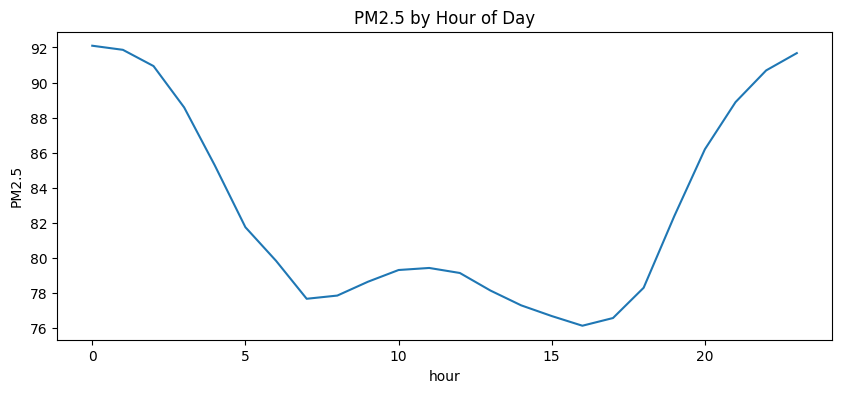

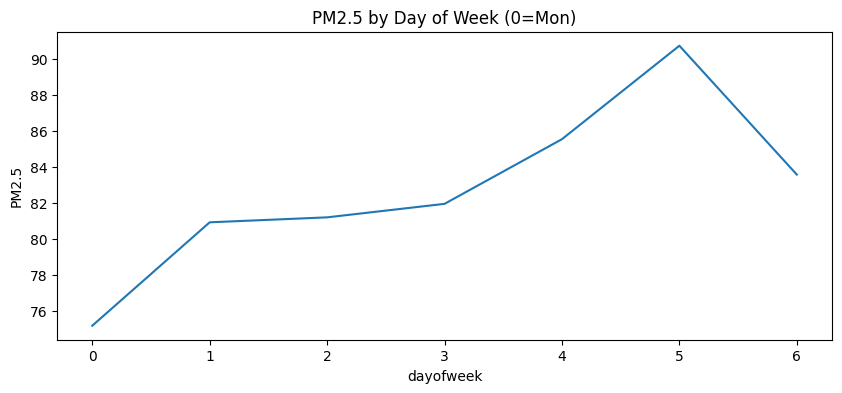

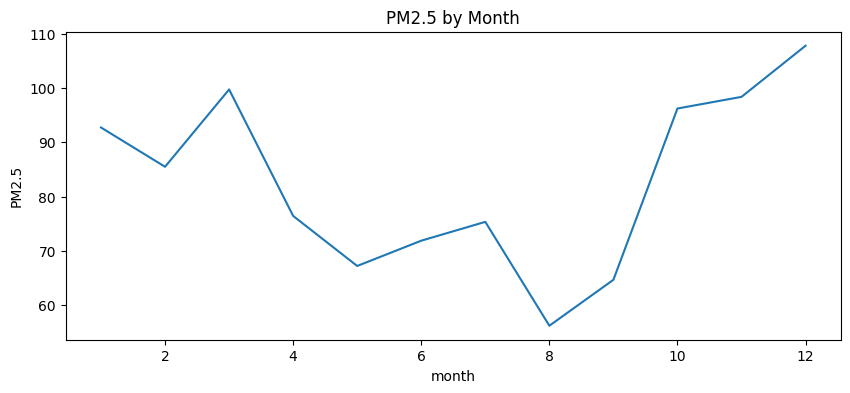

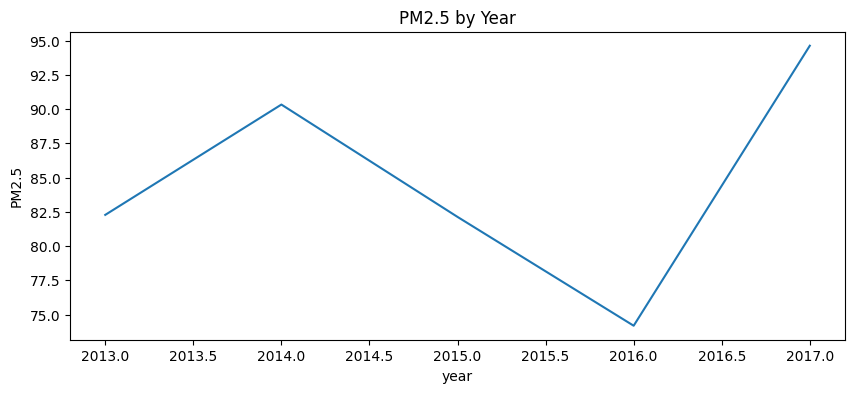

In [324]:
# PM2.5 by hour of day
plt.figure(figsize=(10, 4))
sns.lineplot(x='hour', y=TARGET, data=df.groupby('hour')[TARGET].mean().reset_index())
plt.title('PM2.5 by Hour of Day')
plt.show()

# PM2.5 by day of week
plt.figure(figsize=(10, 4))
sns.lineplot(x='dayofweek', y=TARGET, data=df.groupby('dayofweek')[TARGET].mean().reset_index())
plt.title('PM2.5 by Day of Week (0=Mon)')
plt.show()

# PM2.5 by month
plt.figure(figsize=(10, 4))
sns.lineplot(x='month', y=TARGET, data=df.groupby('month')[TARGET].mean().reset_index())
plt.title('PM2.5 by Month')
plt.show()

# PM2.5 by year
plt.figure(figsize=(10, 4))
sns.lineplot(x='year', y=TARGET, data=df.groupby('year')[TARGET].mean().reset_index())
plt.title('PM2.5 by Year')
plt.show()

### Line graph over time

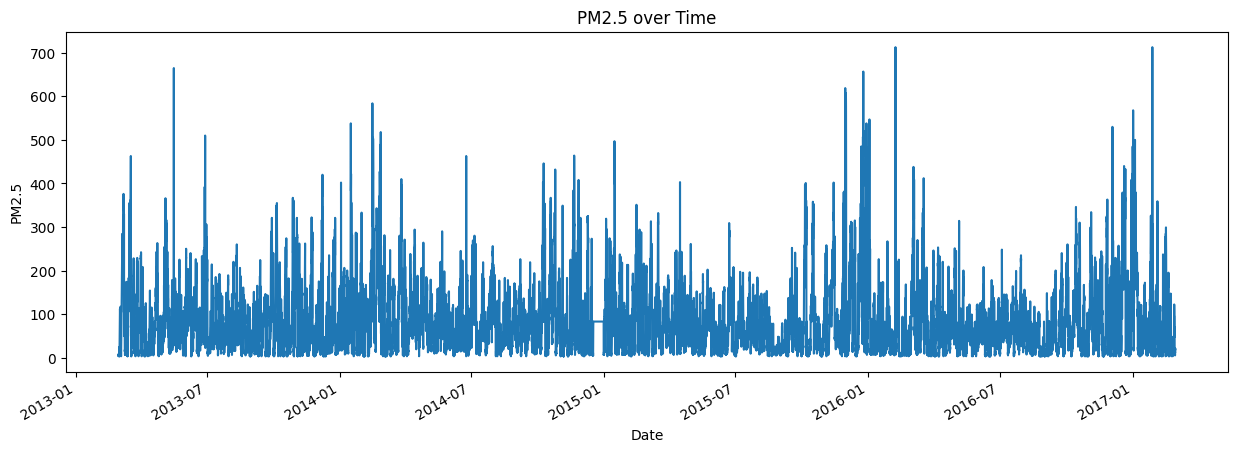

In [325]:
plt.figure(figsize=(15, 5))
df[TARGET].plot()
plt.title('PM2.5 over Time')
plt.ylabel('PM2.5')
plt.xlabel('Date')
plt.show()

## Conclusions

##### The pollution is at its peak at night, most likely when there are the fewest people outside. It is also the most active on Saturday when people are at home, presumably. The coldest months are showing the highest rates of pollution as well, possibly because it's easier to cool down the facilities and it is not exacerbated by the sun heat. The year plot doesn't give a clear understanding, but apparently the tendency of increase pollution is taking its toll.

In [326]:
df.head()

,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,O3,...,wd_NW,wd_S,wd_SE,wd_SSE,wd_SSW,wd_SW,wd_W,wd_WNW,wd_WSW,dayofweek
2013-03-01 00:00:00,2013,3,1,0,4.0,4.0,4.0,7.0,300.0,77.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4
2013-03-01 01:00:00,2013,3,1,1,8.0,8.0,4.0,7.0,300.0,77.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4
2013-03-01 02:00:00,2013,3,1,2,7.0,7.0,5.0,10.0,300.0,73.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4
2013-03-01 03:00:00,2013,3,1,3,6.0,6.0,11.0,11.0,300.0,72.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4
2013-03-01 04:00:00,2013,3,1,4,3.0,3.0,12.0,12.0,300.0,72.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4


In [327]:
df.to_csv(os.path.join(data_folder_path, "POST_EDA_PRSA_Data_Aotizhongxin_20130301-20170228.csv"), index=True, index_label='datetime')